
# Homework Week 2

## ml-zoomcamp 2023 cohort

<hr>

In [1]:
# Importing libraries

# Handling data
import numpy as np
import pandas as pd

# Visualising data
import seaborn as sns
import matplotlib as plt

# Getting data
import wget

In [3]:
# Retrieving the data
wget.download(url="https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

'housing (1).csv'

In [18]:
# Read the data
df = pd.read_csv('housing.csv')
df.shape

(20640, 10)

In [17]:
# Previewing the data
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


[Text(0.5, 0, 'House Value'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Median House Value')]

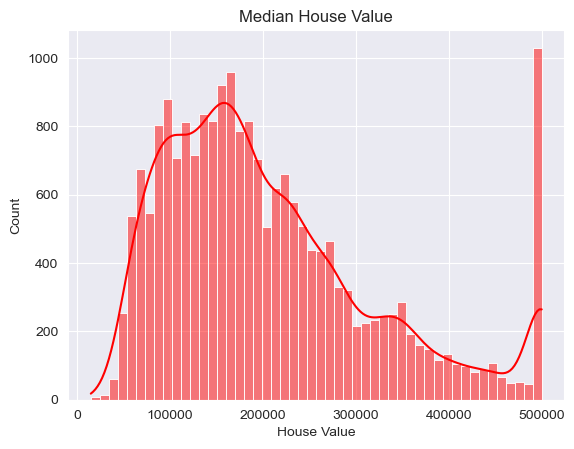

In [13]:
# EDA - Visualising median_house_value
sns.set_style("darkgrid")
plot = sns.histplot(df.median_house_value, bins=50, color="red", kde="True")
plot.set(xlabel="House Value", ylabel="Count", title="Median House Value")

In [22]:
# Filtering data according to the specification
df = df[
    (df.ocean_proximity == 'INLAND') | (df.ocean_proximity == '<1H OCEAN')
    ]
del df['ocean_proximity']

In [23]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


## Question 1 - Checking for NAs

In [25]:
# Checking which series contain NA values and if so how many there are
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

We can see that **total_bedrooms** is the only series which contains any NA values.

## Question 2 - What's the median (50% percentile) for variable 'population'?

In [28]:
# .describe() generates us useful summary statistics
df.population.describe()

count    15687.000000
mean      1466.317205
std       1180.389908
min          3.000000
25%        802.000000
50%       1195.000000
75%       1777.000000
max      35682.000000
Name: population, dtype: float64

The 50% quantile of population is 1195.0

## Question 3

In [30]:
# Shuffling the dataset
# Creating a random order
row, col = df.shape
n = np.arange(row)
np.random.seed(42)
np.random.shuffle(n)

array([15183,  4469,  9316, ...,  5390,   860,  7270])

In [32]:
# Compartmentalising dataset into 60/20/20 train/val/test splits
train = df.iloc[n[:np.int64(len(n)*0.6)]].reset_index(drop="True")
val   = df.iloc[n[np.int64(len(n)*0.6):np.int64(len(n)*0.8)]].reset_index(drop='True')
test  = df.iloc[n[np.int64(len(n)*0.8):]].reset_index(drop='True')

In [33]:
# Creating target vectors and dropping from datasets to form feature matrices
y_train = np.log1p(train.median_house_value.to_numpy())
y_val   = np.log1p(val.median_house_value.to_numpy())
y_test  = np.log1p(test.median_house_value.to_numpy())

del train['median_house_value']
del val['median_house_value']
del test['median_house_value']

In [37]:
# Function to prepare feature matrix - filling NAs with '0'
def prepare_X_null_NA(df):
    df = df.copy()

    for i in df:
        df[i] = df[i].fillna(0)

    X = df

    return X 

In [40]:
# Function to prepare feature matrix - filling NAs with '0'
def prepare_X_mean_NA(df):
    df = df.copy()

    for i in df:
        df[i] = df[i].fillna(train.total_bedrooms.mean())

    X = df

    return X 

In [41]:
# Function to perform linear regression
def linear_regression(X, y, r = 0):
    # First append column of 1s to the front, accounting for w0
    X = np.column_stack([np.ones(X.shape[0]),X])

    # Finding w (Xw = y)
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])    # Regularization step

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [42]:
# Function for calculating the Random Mean Squared Error
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [56]:
# Performing linear regression (NAs = 0)
X_train_null = prepare_X_null_NA(train)

# Finding weights using linear regression
w0_null, w1_null = linear_regression(X_train_null, y_train)
y_pred_train_null = w0_null + X_train_null.dot(w1_null)

# Performing linear regression (NAs = 0)
X_train_mean = prepare_X_mean_NA(train)

# Finding weights using linear regression
w0_mean, w1_mean = linear_regression(X_train_mean, y_train)
y_pred_train_mean = w0_mean + X_train_mean.dot(w1_mean)

print("RMSE (NAs = 0):    {0:20}".format(np.round(rmse(y_train, y_pred_train_null),2)))
print("RMSE (NAs = mean): {0:20}".format(np.round(rmse(y_train, y_pred_train_mean),2)))

RMSE (NAs = 0):                    0.34
RMSE (NAs = mean):                 0.34


Both options have a same RMSE to 2 decimal places, so are **equally good**

## Question 4 - Regularised Linear Regression

In [75]:
X_train = prepare_X_null_NA(train)

r_vec = np.array([0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10])

for r in r_vec:
    w0, w1 = linear_regression(X_train, y_train, r)
    y_pred = w0 + X_train.dot(w1)
    print("RMSE for r =  {0:<10} : {1:<10}".format(r, round(rmse(y_train, y_pred),3)))

RMSE for r =  0.0        : 0.34      
RMSE for r =  1e-06      : 0.34      
RMSE for r =  0.0001     : 0.34      
RMSE for r =  0.001      : 0.34      
RMSE for r =  0.01       : 0.34      
RMSE for r =  0.1        : 0.34      
RMSE for r =  1.0        : 0.343     
RMSE for r =  5.0        : 0.346     
RMSE for r =  10.0       : 0.347     


Given the similar RMSE results **r = 0** is the most appropriate choice of r for regularisation 

## Question 5

In [86]:
seeds = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

for i in seeds:
    # Shuffling the dataset
    # Creating a random order
    row, col = df.shape
    n = np.arange(row)
    np.random.seed(i)
    np.random.shuffle(n)

    # Compartmentalising dataset into 60/20/20 train/val/test splits
    train = df.iloc[n[:np.int64(len(n)*0.6)]].reset_index(drop="True")
    val   = df.iloc[n[np.int64(len(n)*0.6):np.int64(len(n)*0.8)]].reset_index(drop='True')
    test  = df.iloc[n[np.int64(len(n)*0.8):]].reset_index(drop='True')

    # Creating target vectors and dropping from datasets to form feature matrices
    y_train = np.log1p(train.median_house_value.to_numpy())
    y_val   = np.log1p(val.median_house_value.to_numpy())
    y_test  = np.log1p(test.median_house_value.to_numpy())

    del train['median_house_value']
    del val['median_house_value']
    del test['median_house_value']

    # Initialising the feature matrices
    X_train = prepare_X_null_NA(train)
    X_val   = prepare_X_null_NA(val)

    # Training the model
    w0, w1 = linear_regression(X_train, y_train, 0)

    # Calculating y predictions
    y_train_pred = w0 + X_train.dot(w1)
    y_val_pred   = w0 + X_val.dot(w1)

    print("Seed: ", i)
    print("RMSE (Train): {0:10}".format(rmse(y_train,y_train_pred)))
    print("RMSE (Val):   {0:10}".format(rmse(y_val,y_val_pred)))
    print("Standard Deivation: {0:10}".format(np.round(np.std([rmse(y_train,y_train_pred),rmse(y_val,y_val_pred)]),3)))
    print()

Seed:  0
RMSE (Train): 0.33299496833639686
RMSE (Val):   0.3377846115210822
Standard Deivation:      0.002

Seed:  1
RMSE (Train): 0.33533597292130257
RMSE (Val):   0.3378066543009298
Standard Deivation:      0.001

Seed:  2
RMSE (Train): 0.3402820960258962
RMSE (Val):   0.33846044731881775
Standard Deivation:      0.001

Seed:  3
RMSE (Train): 0.34113896851455816
RMSE (Val):   0.3320086319057813
Standard Deivation:      0.005

Seed:  4
RMSE (Train): 0.3347873932153578
RMSE (Val):   0.33944492069602683
Standard Deivation:      0.002

Seed:  5
RMSE (Train): 0.33828727163333333
RMSE (Val):   0.34337807814846283
Standard Deivation:      0.003

Seed:  6
RMSE (Train): 0.3373648087118994
RMSE (Val):   0.33853387112813416
Standard Deivation:      0.001

Seed:  7
RMSE (Train): 0.3340873641367258
RMSE (Val):   0.34814297152954615
Standard Deivation:      0.007

Seed:  8
RMSE (Train): 0.3346145916732098
RMSE (Val):   0.3512727798516247
Standard Deivation:      0.008

Seed:  9
RMSE (Train): 0.341

Standard deviation (std) is roughly **0.005** (all values are to 3 decimal places)

## Question 6 - Testing a Model

In [93]:
seed = 9

# Shuffling the dataset
# Creating a random order
row, col = df.shape
n = np.arange(row)
np.random.seed(seed)
np.random.shuffle(n)

# Compartmentalising dataset into 60/20/20 train/val/test splits
train = df.iloc[n[:np.int64(len(n)*0.6)]].reset_index(drop="True")
val   = df.iloc[n[np.int64(len(n)*0.6):np.int64(len(n)*0.8)]].reset_index(drop='True')
test  = df.iloc[n[np.int64(len(n)*0.8):]].reset_index(drop='True')

# Creating target vectors and dropping from datasets to form feature matrices
y_train = np.log1p(train.median_house_value.to_numpy())
y_val   = np.log1p(val.median_house_value.to_numpy())
y_test  = np.log1p(test.median_house_value.to_numpy())

del train['median_house_value']
del val['median_house_value']
del test['median_house_value']

# Combining train and validation datasets
train_val = pd.concat([train, val])
y_train_val = np.concatenate([y_train, y_val])

X_train_val = prepare_X_null_NA(train_val)
X_test      = prepare_X_null_NA(test)

w0, w1 = linear_regression(X_train_val, y_train_val, 0.001)

y_pred_test = w0 + X_test.dot(w1)

print("RMSE: {0:10}".format(round(rmse(y_test, y_pred_test),2)))


RMSE:       0.33


Training the model on our combined `train` and `validation` splits and then testing the model on our `test` split gives and **RMSE = 0.33** 